<a href="https://colab.research.google.com/github/OlyKoek/MyStudy-AI-app/blob/colab/create_multimodal_embeding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# マルチモーダルなエンベディングモデルの作成

#### 日本語表示対応

In [1]:
# 日本語フォントをダウンロードする。
!apt-get -y install fonts-ipafont-gothic
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'IPAGothic'

import shutil
import os
# フォントキャッシュを削除
font_cache_path = os.path.expanduser("~/.cache/matplotlib")
if os.path.exists(font_cache_path):
    shutil.rmtree(font_cache_path)


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


### Pytorchのパッケージと必要なライブラリをインストール
- torch   
- transformers from hugging face
- umap-learn : 可視化で使ってみたい。t-SNEよりも良いらしい
- matplotlib : ベクトル空間の可視化に使用

In [2]:
!pip install torch torchvision torchaudio --quiet
!pip install transformers umap-learn matplotlib pandas scikit-learn --quiet

# 概要
やりたいことは、マルチモーダルな入力をベクトル空間に投影すること。
今回はできるだけ簡単に構築したいので、下記の構成。

- テキスト：TinyBERT系   
(最初all-MiniLM-L6-v2を使ったけど、日本語使えないことに気が付いたので一旦sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2に変更。東北大学が作った日本語専用のbert-base-japanese-v2もよさげだけど。一旦これで行く。)
- 画像：CLIP
- 音：MCFF

## Step1 テキストのEmbedding

ここでは、大規模コーパスで学習済のTinyBERTを**特徴量抽出器**として扱い、
その出力をLiner層(Projection Head)を使って、マルチモーダル用の次元圧縮と
好きな意味空間になるように調整を行う。ざっくり言うと、プロジェクションヘッドを使った転移学習。

step1: TinyBERTにテキストを入力してエンコード   
step2: エンコード結果をLiner層で次元圧縮しつつ、任意の意味空間になるような学習をさせる    
Step3: 好きなテキストをTinyBERT+Linerに入れると、Step2の学習に従ったベクトル意味空間にプロットされる。

In [3]:
from transformers import AutoTokenizer, AutoModel
import torch

# read TinyBERT model
MODEL_NAME = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

# test sample text
texts = ["今日めっちゃ良かった楽しい","マジつまんね。つらい","今日は普通かな特に何もないし"]

# tokenize
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")


# test ==========================
# view to tokenizerd text
print("-"*50)
text = texts[0]
tokens = tokenizer.tokenize(text)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(f"Tokenizeの出力確認\n\n 入力文章：{text} \nトークン文字：{tokens} \nトークンID: {ids}")
print("-"*50)
# ==============================


# input tokenized data to TinyBERT model
with torch.no_grad():
    outputs = model(**inputs)

# convert token to vector
embeddings = outputs.last_hidden_state.mean(dim=1)
print("\n文数 =",embeddings.shape[0]," ベクトル次元 =", embeddings.shape[1])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


--------------------------------------------------
Tokenizeの出力確認

 入力文章：今日めっちゃ良かった楽しい 
トークン文字：['▁', '今日', 'め', 'っちゃ', '良かった', '楽しい'] 
トークンID: [6, 21834, 8421, 101963, 82989, 82672]
--------------------------------------------------

文数 = 3  ベクトル次元 = 384


### Linearヘッドを追加して256次元に射影

 射影：今回使ったTinyBERTのディフォルトの埋め込みベクトル次元空間を、別のベクトル次元目的空間に変換するための、線形変換を適応

 今回はテキスト以外も同じ特徴空間にプロットするので、共有可能なベクトル次元空間にする必要がある。


In [4]:
import torch.nn as nn

projector = nn.Linear(embeddings.shape[1], 256)

#射影
projected = projector(embeddings)
print(projected.shape)

torch.Size([3, 256])


#### 対象学習　ベクトル同士の意味付け

似た意味の単語を近く人、反対の意味の単語を遠くに、という形でベクトル空間上のプロットを最適化して、自然にクラスタ化されるようにする。


In [5]:
import pandas as pd

data = {
    "anchor": ["嬉しい", "悲しい", "疲れた", "ワクワクする", "寂しい", "楽しい"],
    "positive": ["楽しい", "つらい", "だるい", "楽しみ", "悲しい", "嬉しい"],
    "negative": ["怒っている", "嬉しい", "ワクワクする", "眠い", "明るい", "悲しい"]
}
df = pd.DataFrame(data)
df

,anchor,positive,negative
0,嬉しい,楽しい,怒っている
1,悲しい,つらい,嬉しい
2,疲れた,だるい,ワクワクする
3,ワクワクする,楽しみ,眠い
4,寂しい,悲しい,明るい
5,楽しい,嬉しい,悲しい


In [6]:
from torch.nn import functional as F

def encode_texts(text_list):
  inputs = tokenizer(text_list, padding=True, truncation=True, return_tensors="pt")
  with torch.no_grad():
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

# 各文をエンコード
anchor_emb = encode_texts(df["anchor"].tolist())
pos_emb = encode_texts(df["positive"].tolist())
neg_emb = encode_texts(df["negative"].tolist())

# 正例：anchorとposを近づける
pos_sim = F.cosine_similarity(anchor_emb, pos_emb)
# 負例：anchorとnegを離す
neg_sim = F.cosine_similarity(anchor_emb, neg_emb)

# InfoNCE風のloss（シンプル版）
loss = -torch.log(torch.exp(pos_sim) / (torch.exp(pos_sim) + torch.exp(neg_sim)))
loss = loss.mean()
print(f"Contrastive Loss: {loss.item():.4f}")

Contrastive Loss: 0.5850


In [7]:
optimizer = torch.optim.AdamW(projector.parameters(), lr=1e-4)

for epoch in range(10):
    optimizer.zero_grad()
    anchor_emb = encode_texts(df["anchor"].tolist())
    pos_emb = encode_texts(df["positive"].tolist())
    neg_emb = encode_texts(df["negative"].tolist())

    pos_sim = F.cosine_similarity(projector(anchor_emb), projector(pos_emb))
    neg_sim = F.cosine_similarity(projector(anchor_emb), projector(neg_emb))
    loss = -torch.log(torch.exp(pos_sim) / (torch.exp(pos_sim) + torch.exp(neg_sim))).mean()

    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")


Epoch 1 | Loss: 0.5902
Epoch 2 | Loss: 0.5784
Epoch 3 | Loss: 0.5663
Epoch 4 | Loss: 0.5537
Epoch 5 | Loss: 0.5408
Epoch 6 | Loss: 0.5276
Epoch 7 | Loss: 0.5141
Epoch 8 | Loss: 0.5003
Epoch 9 | Loss: 0.4862
Epoch 10 | Loss: 0.4720


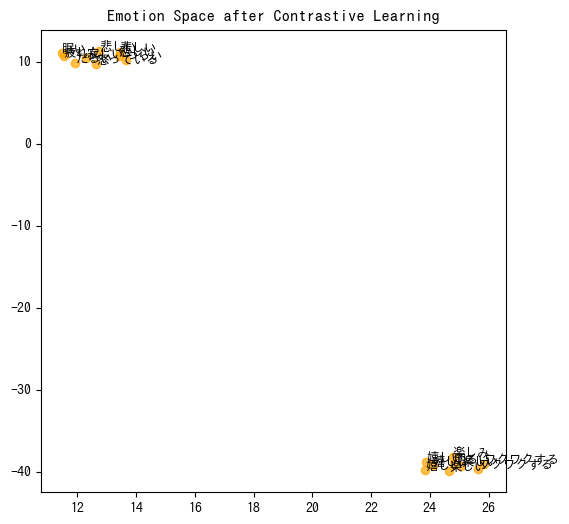

In [8]:
all_texts = df["anchor"].tolist() + df["positive"].tolist() + df["negative"].tolist()
embeddings = encode_texts(all_texts)
projected = projector(embeddings).detach().numpy()

import umap, matplotlib.pyplot as plt
reducer = umap.UMAP(metric="cosine", n_neighbors=5, min_dist=0.3)
umap_emb = reducer.fit_transform(projected)

plt.figure(figsize=(6,6))
plt.scatter(umap_emb[:,0], umap_emb[:,1], c="orange", alpha=0.7)
for i, t in enumerate(all_texts):
    plt.text(umap_emb[i,0], umap_emb[i,1], t, fontsize=9)
plt.title("Emotion Space after Contrastive Learning")
plt.show()


## Step2 画像のEmbedding

ここでは、大規模コーパスで学習済のTinyBERTを**特徴量抽出器**として扱い、
その出力をLiner層(Projection Head)を使って、マルチモーダル用の次元圧縮と
好きな意味空間になるように調整を行う。ざっくり言うと、プロジェクションヘッドを使った転移学習。

step1: TinyBERTにテキストを入力してエンコード   
step2: エンコード結果をLiner層で次元圧縮しつつ、任意の意味空間になるような学習をさせる    
Step3: 好きなテキストをTinyBERT+Linerに入れると、Step2の学習に従ったベクトル意味空間にプロットされる。

In [11]:
import torch
import torchvision.models as models
import torchvision.transforms as T
from PIL import Image
import requests
from io import BytesIO

# MobileNetV3 Small（軽量）
image_model = models.mobilenet_v3_small(pretrained=True)
image_model.eval()  # 学習しない（凍結）

# 最終層直前の512次元ベクトルを得るためのhook
# MobileNetV3の特徴抽出部だけを使う
feature_extractor = image_model.features

# 画像前処理
image_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 61.6MB/s]


In [12]:
def encode_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    tensor = image_transform(img).unsqueeze(0)  # [1,3,224,224]

    with torch.no_grad():
        feat = feature_extractor(tensor)  # [1, 576, 7,7]
        feat = torch.mean(feat, dim=[2,3])  # 平均プーリング → [1, 576]

    return feat

# テスト画像（犬）
test_url = "https://images.dog.ceo/breeds/chow/n02112137_16777.jpg"
img_emb = encode_image(test_url)
print(img_emb.shape)



torch.Size([1, 576])


In [13]:
import torch.nn as nn

# MobileNetV3-Small の最終特徴量は 576 次元
image_projector = nn.Linear(576, 256)

# TinyBERT 用 projector（すでにあるはず）
text_projector = projector  # 前フェーズで作った 384 → 256 Linear


In [30]:
image_text_pairs = [
    {
        "url": "https://images.dog.ceo/breeds/chow/n02112137_16777.jpg",
        "text": "白いフワフワの犬"
    },
    {
        "url": "https://images.dog.ceo/breeds/pitbull/20190710_143021.jpg",
        "text": "黒と白の犬が緑の草原の中にいる"
    },
    {
        "url": "https://images.dog.ceo/breeds/poodle-toy/n02113624_9550.jpg",
        "text": "ふわふわの子犬の写真"
    },
    {
        "url": "https://images.dog.ceo/breeds/eskimo/n02109961_8185.jpg",
        "text": "白い犬が石畳の上に座っている"
    }
]


In [57]:
def encode_text_256(text):
    with torch.no_grad():
        emb = encode_texts([text])      # TinyBERT → [1,384]
        proj = text_projector(emb)      # projector → [1,256]
        proj = proj / (proj.norm(dim=-1, keepdim=True) + 1e-8)
    return proj

def encode_image_256(url):
    with torch.no_grad():
        feat = encode_image(url)        # MobileNet → [1,576]
        proj = image_projector(feat)    # projector → [1,256]
        proj = proj / (proj.norm(dim=-1, keepdim=True) + 1e-8)
    return proj

In [58]:
img_vec = encode_image_256(image_text_pairs[0]["url"])
txt_vec = encode_text_256(image_text_pairs[0]["text"])
print(img_vec.shape, txt_vec.shape)


torch.Size([1, 256]) torch.Size([1, 256])


In [59]:
optimizer = torch.optim.AdamW(
    list(image_projector.parameters()) +
    list(text_projector.parameters()),
    lr=1e-4
)

def contrastive_loss(img_vecs, txt_vecs):
    # cosine similarity matrix
    sim_matrix = torch.matmul(
        img_vecs,
        txt_vecs.T
    )  # [batch, batch]

    # 温度パラメータ（CLIP論文と同じ）
    temperature = 0.07
    sim_matrix = sim_matrix / temperature

    # 正解 = 対角線（ペア）
    labels = torch.arange(len(sim_matrix)).long()

    loss_i = torch.nn.CrossEntropyLoss()(sim_matrix, labels)
    loss_t = torch.nn.CrossEntropyLoss()(sim_matrix.T, labels)
    return (loss_i + loss_t) / 2


# 学習ループ
for epoch in range(20):
    optimizer.zero_grad()

    img_vecs = []
    txt_vecs = []

    for pair in image_text_pairs:
        img_vecs.append(encode_image_256(pair["url"]))
        txt_vecs.append(encode_text_256(pair["text"]))

    img_vecs = torch.cat(img_vecs, dim=0)
    txt_vecs = torch.cat(txt_vecs, dim=0)

    loss = contrastive_loss(img_vecs, txt_vecs)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [60]:
query = "ふわふわの犬"
q_vec = encode_text_256(query)

sims = torch.nn.functional.cosine_similarity(
    q_vec, img_vecs
)
print(sims)


tensor([ 0.0990, -0.1112,  0.1689, -0.0131])


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


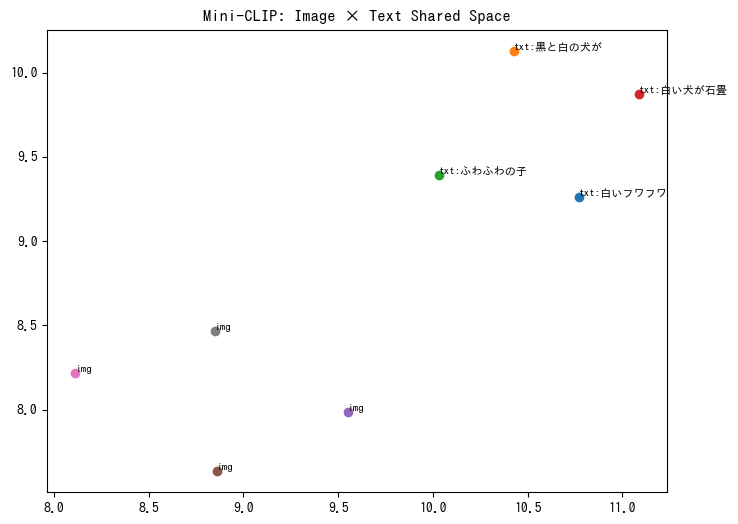

In [61]:
import numpy as np
import umap
import matplotlib.pyplot as plt

all_vecs = []
labels = []

# text
for pair in image_text_pairs:
    all_vecs.append(encode_text_256(pair["text"]).detach().numpy())
    labels.append("txt:" + pair["text"])

# image
for pair in image_text_pairs:
    all_vecs.append(encode_image_256(pair["url"]).detach().numpy())
    labels.append("img")

all_vecs = np.vstack(all_vecs)

reducer = umap.UMAP(metric="cosine")
umap_vecs = reducer.fit_transform(all_vecs)

plt.figure(figsize=(8,6))
for i, lab in enumerate(labels):
    plt.scatter(umap_vecs[i,0], umap_vecs[i,1])
    plt.text(umap_vecs[i,0], umap_vecs[i,1], lab[:10], fontsize=8)

plt.title("Mini-CLIP: Image × Text Shared Space")
plt.show()


## ベクトルDBを作成

In [62]:
vector_db = []  # ここにすべての埋め込みを保存

def build_vector_db(pairs):
    for pair in pairs:
        # テキスト埋め込み
        txt_vec = encode_text_256(pair["text"]).cpu().detach().numpy()
        vector_db.append({
            "type": "text",
            "text": pair["text"],
            "url": pair["url"],   # 画像と紐付いてる場合
            "vec": txt_vec
        })

        # 画像埋め込み
        img_vec = encode_image_256(pair["url"]).cpu().detach().numpy()
        vector_db.append({
            "type": "image",
            "text": pair["text"],
            "url": pair["url"],
            "vec": img_vec
        })

# test for vector db

In [63]:
build_vector_db(image_text_pairs)
len(vector_db)


8

## TEST

In [64]:
q_vec = encode_text_256("ふわふわの子犬").detach().cpu().numpy()

print("q norm:", np.linalg.norm(q_vec))

for item in vector_db:
    print(item["type"], cosine_sim(q_vec, item["vec"]))


q norm: 1.0
text 0.74434924
image 0.07980666
text 0.53932786
image -0.12356053
text 0.9223178
image 0.17633879
text 0.5607993
image -0.008931433


In [65]:
import numpy as np

def cosine_sim(a, b):
    # Ensure inputs are 1D arrays for dot product and norm calculation
    a_flat = a.flatten()
    b_flat = b.flatten()
    return np.dot(a_flat, b_flat) / (np.linalg.norm(a_flat) * np.linalg.norm(b_flat) + 1e-8)

def search_db(query_vec, top_k=5, mode=None):
    results = []
    for item in vector_db:

        if mode is not None:
            if item["type"] != mode:  # "image" or "text"
                continue

        sim = cosine_sim(query_vec, item["vec"])
        results.append((sim, item))

    results.sort(reverse=True, key=lambda x: x[0])
    return results[:top_k]

In [68]:
def pretty_print_results(results):
    for sim, item in results:
        print(f"sim={sim:.3f} | type={item['type']} | text={item['text']} | url={item['url']}")


In [69]:
query = "ふわふわの子犬"
q_vec = encode_text_256(query).cpu().detach().numpy()

results = search_db(q_vec, top_k=5)
pretty_print_results(results)


sim=0.922 | type=text | text=ふわふわの子犬の写真 | url=https://images.dog.ceo/breeds/poodle-toy/n02113624_9550.jpg
sim=0.744 | type=text | text=白いフワフワの犬 | url=https://images.dog.ceo/breeds/chow/n02112137_16777.jpg
sim=0.561 | type=text | text=白い犬が石畳の上に座っている | url=https://images.dog.ceo/breeds/eskimo/n02109961_8185.jpg
sim=0.539 | type=text | text=黒と白の犬が緑の草原の中にいる | url=https://images.dog.ceo/breeds/pitbull/20190710_143021.jpg
sim=0.176 | type=image | text=ふわふわの子犬の写真 | url=https://images.dog.ceo/breeds/poodle-toy/n02113624_9550.jpg


In [71]:

img_url = "https://images.dog.ceo/breeds/eskimo/n02109961_8185.jpg"
q_vec = encode_image_256(img_url).cpu().detach().numpy()

results = search_db(q_vec, top_k=5)
pretty_print_results(results)

sim=1.000 | type=image | text=白い犬が石畳の上に座っている | url=https://images.dog.ceo/breeds/eskimo/n02109961_8185.jpg
sim=0.740 | type=image | text=白いフワフワの犬 | url=https://images.dog.ceo/breeds/chow/n02112137_16777.jpg
sim=0.633 | type=image | text=ふわふわの子犬の写真 | url=https://images.dog.ceo/breeds/poodle-toy/n02113624_9550.jpg
sim=0.409 | type=image | text=黒と白の犬が緑の草原の中にいる | url=https://images.dog.ceo/breeds/pitbull/20190710_143021.jpg
sim=0.119 | type=text | text=白い犬が石畳の上に座っている | url=https://images.dog.ceo/breeds/eskimo/n02109961_8185.jpg


In [53]:
from PIL import Image
import requests
from IPython.display import display

def show(item):
    print(f"type: {item['type']}, text: {item['text']}, url: {item['url']}")
    if item["type"] == "image":
        img = Image.open(requests.get(item["url"], stream=True).raw)
        display(img)


In [54]:
for sim, item in results:
    print(f"sim={sim:.3f}")
    show(item)
